In [186]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-price/Data_Train.xlsx
/kaggle/input/flight-price/Test_set.xlsx


In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [188]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [189]:
data = pd.read_excel('/kaggle/input/flight-price/Data_Train.xlsx')
print("Shape of data: ", data.shape)
data.head()

Shape of data:  (10683, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## *There are 10,683 flight records, and 11 features.* <br>

## Features: <br>
1. Airline: String (Flight company)<br>
2. Date of Journey (Date)<br>
3. Dep Time/ Arrival Time/ Duration (Flight time)<br>
4. Source/Destination/Route/ Total Stops (Flight path)<br>
5. Additional info<br>
6. Price (Target feature)

## **According to me:**<br>
1. Source and Destination is not required. It is covered in Route<br>
2. The route needs to be converted into meaningful features.<br>
3. Total stops and Route are somewhat related<br>
4. Out of Dep Time/ Arrival Time and Duration, only two features are important. The third one is dependent on other two<br>
5. Additional info is mostly a sparse feature<br>

# Cleaning the data

## Step 1: Missing values

In [190]:
data.isnull().any()

Airline            False
Date_of_Journey    False
Source             False
Destination        False
Route               True
Dep_Time           False
Arrival_Time       False
Duration           False
Total_Stops         True
Additional_Info    False
Price              False
dtype: bool

We find that there are missing values in **Route** and **Total_Stops**

In [191]:
data.loc[data["Total_Stops"].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [192]:
#Checking what are the values that the Total_Stops take
data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [193]:
#Filling the missing value
data.loc[data["Total_Stops"].isnull(),"Total_Stops"] = "1 stop"

In [194]:
# Checking missing values in Route
data.loc[data["Route"].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,1 stop,No info,7480


In [195]:
#Checking what are the values that the Route take
data["Route"].value_counts()

DEL → BOM → COK                2376
BLR → DEL                      1552
CCU → BOM → BLR                 979
CCU → BLR                       724
BOM → HYD                       621
                               ... 
BLR → HBX → BOM → AMD → DEL       1
BOM → UDR → DEL → HYD             1
CCU → RPR → HYD → BLR             1
BOM → COK → MAA → HYD             1
BOM → NDC → HYD                   1
Name: Route, Length: 128, dtype: int64

In [196]:
#Filling the missing value
data.loc[data["Route"].isnull(),"Route"] = "DEL → COK"

## Step 2: Data Formatting

1. Airline: Nominal Categorical<br>
2. Date_of_Journey: Numerical<br>
3. Source/Destination/Route: Nominal Categorical<br>
4. Dep Time/ Arrival Time/ Duration : Numerical<br>
5. Total_Stops: Ordinal Categorical<br>
6. Addditional info: Nominal Categorical<br>

### 2.1 Mapping Ordinal feature: Total Stops

In [197]:
data["Total_Stops"].value_counts()

1 stop      5626
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [198]:
stops_map = {"non-stop": 0,
             "1 stop": 1,
             "2 stops": 2,
             "3 stops": 3,
             "4 stops": 4}

In [199]:
data["Total_Stops"] = data["Total_Stops"].map(stops_map)

In [200]:
data["Total_Stops"].value_counts()

1    5626
0    3491
2    1520
3      45
4       1
Name: Total_Stops, dtype: int64

### 2.2 Preprocessing Source, Destination and Route features

In [201]:
route_df = data["Route"].str.split("→")

In [202]:
route_df.head()

0                  [BLR ,  DEL]
1    [CCU ,  IXR ,  BBI ,  BLR]
2    [DEL ,  LKO ,  BOM ,  COK]
3           [CCU ,  NAG ,  BLR]
4           [BLR ,  NAG ,  DEL]
Name: Route, dtype: object

In [203]:
for index in data.index:
    data.loc[index, "Source"] = route_df[index][0].strip()
    data.loc[index, "Destination"] = route_df[index][-1].strip()
    del route_df[index][0]
    del route_df[index][-1]

In [204]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,BLR,DEL,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897
1,Air India,1/05/2019,CCU,BLR,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662
2,Jet Airways,9/06/2019,DEL,COK,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882
3,IndiGo,12/05/2019,CCU,BLR,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218
4,IndiGo,01/03/2019,BLR,DEL,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302


In [205]:
route_df.head()

0                []
1    [ IXR ,  BBI ]
2    [ LKO ,  BOM ]
3           [ NAG ]
4           [ NAG ]
Name: Route, dtype: object

In [206]:
route_df = route_df.apply(pd.Series)

In [207]:
route_df.rename({0:'Stop_1', 1:'Stop_2', 2:'Stop_3', 3:'Stop_4'}, axis = 'columns', inplace = True)

In [208]:
route_df.head()

,Stop_1,Stop_2,Stop_3,Stop_4
0,NaN,NaN,NaN,NaN
1,IXR,BBI,NaN,NaN
2,LKO,BOM,NaN,NaN
3,NAG,NaN,NaN,NaN
4,NAG,NaN,NaN,NaN


In [209]:
data.drop(labels=['Route'], axis= 'columns', inplace=True)

In [210]:
new_data = pd.concat([data, route_df], axis =1)

In [211]:
new_data.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,24/03/2019,BLR,DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,1/05/2019,CCU,BLR,05:50,13:15,7h 25m,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,9/06/2019,DEL,COK,09:25,04:25 10 Jun,19h,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,12/05/2019,CCU,BLR,18:05,23:30,5h 25m,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,01/03/2019,BLR,DEL,16:50,21:35,4h 45m,1,No info,13302,NAG,NaN,NaN,NaN


### *Source and Destination are Important Features than Intermediate Stops, hence kept them as seperate features*

### 2.3 Preprocessing Dep_time, Arrival_Time and Duration 

In [212]:
new_data["Dep_Time"].head()

0    22:20
1    05:50
2    09:25
3    18:05
4    16:50
Name: Dep_Time, dtype: object

In [213]:
new_data["Arrival_Time"].head()

0    01:10 22 Mar
1           13:15
2    04:25 10 Jun
3           23:30
4           21:35
Name: Arrival_Time, dtype: object

In [214]:
new_data["Duration"].head()

0    2h 50m
1    7h 25m
2       19h
3    5h 25m
4    4h 45m
Name: Duration, dtype: object

As we can see,<br>

Departure Time and Duration ae well formatted.<br>
However, Arrival Time is not well formatted. It would take a lot of time to clean it to make it usable.<br>

In [215]:
#Converting Departure Time and Duration into datetime format
new_data["Dep_Time"] = pd.to_datetime(new_data["Date_of_Journey"]+ ' ' + new_data["Dep_Time"])

In [216]:
new_data["Dep_Time"].head()

0   2019-03-24 22:20:00
1   2019-01-05 05:50:00
2   2019-09-06 09:25:00
3   2019-12-05 18:05:00
4   2019-01-03 16:50:00
Name: Dep_Time, dtype: datetime64[ns]

In [217]:
new_data.drop(labels=["Date_of_Journey", "Arrival_Time"], axis= 'columns', inplace = True)

In [218]:
new_data.head()

,Airline,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,BLR,DEL,2019-03-24 22:20:00,2h 50m,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,CCU,BLR,2019-01-05 05:50:00,7h 25m,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,DEL,COK,2019-09-06 09:25:00,19h,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,CCU,BLR,2019-12-05 18:05:00,5h 25m,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,BLR,DEL,2019-01-03 16:50:00,4h 45m,1,No info,13302,NAG,NaN,NaN,NaN


In [219]:
#TODO: Convert Duration to proper datetime format using regex and datetime functions

#TODO: Check contents of Additional_Info

#TODO: Seperate Price (y) and reemaing data (X)

#TODO: One Hot Encode these features: 'Airline', 'Additional_Info', 'Stop_<all>'

#Then the data will be ready to be used in any Regression model.

In [220]:
#Finding all numbers in a string
import re
duration_series = new_data["Duration"].str.findall(r'\d+')

In [221]:
duration_series.head()

0    [2, 50]
1    [7, 25]
2       [19]
3    [5, 25]
4    [4, 45]
Name: Duration, dtype: object

In [222]:
from datetime import datetime
from datetime import timedelta
for i, duration_list in enumerate(duration_series.values):
    hours = int(duration_list[0])
    if len(duration_list)==1:
        mins = 0
    else:
        mins = int(duration_list[1])
        
    new_data.loc[i, "Duration"] = 60*hours + mins

In [223]:
new_data.rename(columns={"Duration": "Minutes"}, inplace = True)

In [224]:
new_data.head()

,Airline,Source,Destination,Dep_Time,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,BLR,DEL,2019-03-24 22:20:00,170,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,CCU,BLR,2019-01-05 05:50:00,445,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,DEL,COK,2019-09-06 09:25:00,1140,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,CCU,BLR,2019-12-05 18:05:00,325,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,BLR,DEL,2019-01-03 16:50:00,285,1,No info,13302,NAG,NaN,NaN,NaN


### 2.4 Checking Additional_Info

In [225]:
new_data["Additional_Info"].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

# Visaulizations and Plottings

## Describing the features

In [226]:
new_data.describe()

,Total_Stops,Price
count,10683.000000,10683.000000
mean,0.824207,9087.064121
std,0.675199,4611.359167
min,0.000000,1759.000000
25%,0.000000,5277.000000
50%,1.000000,8372.000000
75%,1.000000,12373.000000
max,4.000000,79512.000000


### ***These are the only numerical features in our dataset***

## Plotting Numerical features

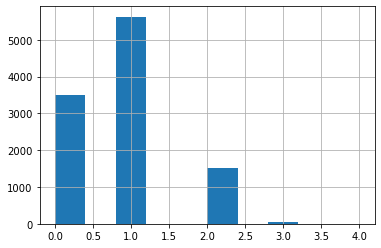

In [227]:
new_data["Total_Stops"].hist()

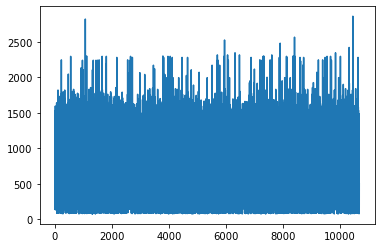

In [228]:
new_data["Minutes"].plot()

The plot for Minutes is highly noisy.
So, we should try to create bins and plot it to de-noise it. Therefore, let us try Histogram<br> (Default bins are 10)

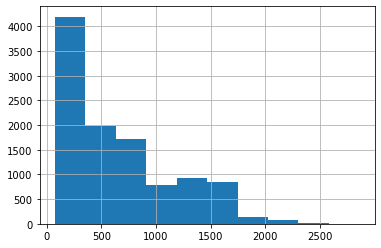

In [229]:
new_data["Minutes"].hist()

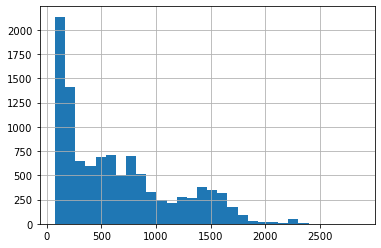

In [230]:
#So let us try to increase bins
new_data["Minutes"].hist(bins=30)

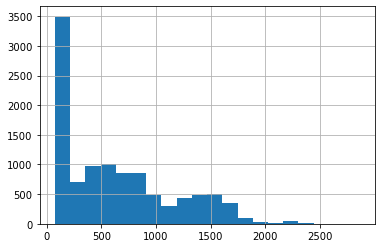

In [231]:
new_data["Minutes"].hist(bins=20)

**Minutes feature is highly right skewed with average at 520 minutes**

## Plotting Categorical Features

## 1. Plotting Airline

In [232]:
new_data.groupby('Airline')['Price'].mean()

Airline
Air Asia                              5590.260188
Air India                             9611.210616
GoAir                                 5861.056701
IndiGo                                5673.682903
Jet Airways                          11643.923357
Jet Airways Business                 58358.666667
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
SpiceJet                              4338.284841
Trujet                                4140.000000
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Name: Price, dtype: float64

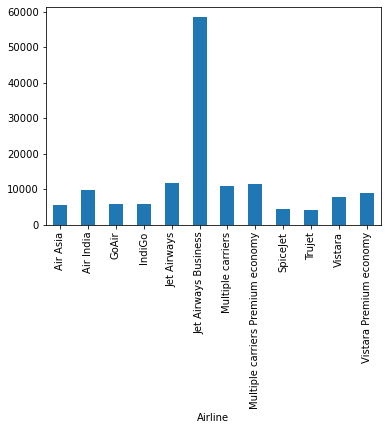

In [233]:
airline_grouped = new_data.groupby('Airline')['Price'].mean()
airline_grouped.plot.bar()

**Jet Airaways Business has an extremely high price.
In airlines feature, Jet Airways Buisness is highly determining of the price of flight**

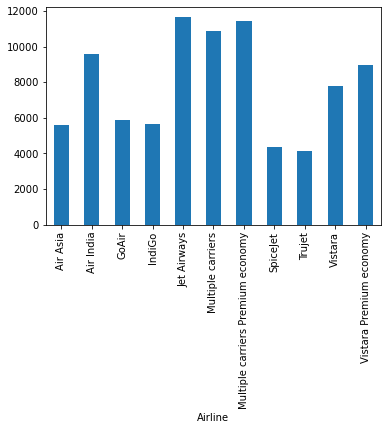

In [234]:
#Plotting again, without Jet Airways Business
airlines_excluded_grouped = airline_grouped.drop(['Jet Airways Business'])
airlines_excluded_grouped.plot.bar()

### Not much can be inferred.

## 2. Checking Prices Monthly

In [235]:
new_data['Dep_Time'] = pd.to_datetime(new_data['Dep_Time'])

In [236]:
new_data.groupby(new_data["Dep_Time"].dt.month)["Price"].mean()

Dep_Time
1     10492.642791
3      8433.839891
4      5230.860849
5      9361.077628
6      9214.964905
9      9551.474395
12     9110.774295
Name: Price, dtype: float64

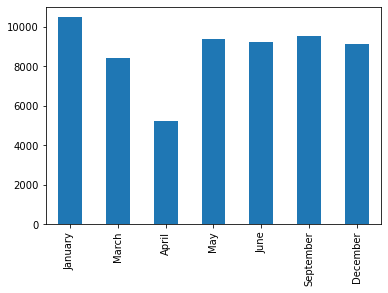

In [237]:
month_average = new_data.groupby(new_data["Dep_Time"].dt.month)["Price"].mean()
month_average.index = ["January", "March", "April", "May", "June", "September", "December"]
month_average.plot.bar()

**Prices dipped in April. Highest in January**

### Is there a relation between the Day of the ticket booked?

In [238]:
new_data.groupby(new_data["Dep_Time"].dt.day_name())["Price"].mean()

Dep_Time
Friday       8556.502220
Monday       9721.101945
Saturday     8894.375727
Sunday       9556.827684
Thursday     9805.088646
Tuesday      8960.452265
Wednesday    7996.290807
Name: Price, dtype: float64

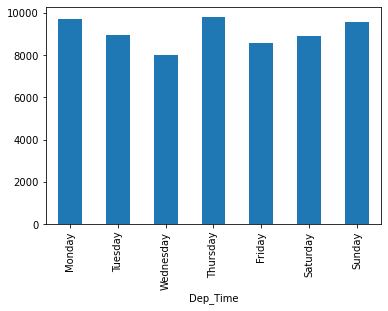

In [239]:
days = ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_grouped = new_data.groupby(new_data["Dep_Time"].dt.day_name())["Price"].mean().reindex(days)
weekday_grouped.plot.bar()

1. Sunday, Monday and Thursday one of the highest.<br>
2. Prices dip from Monday to Wednesday and increases from Friday to Sunday

### Is there any relation between the day of the month the ticket is booked?

In [240]:
new_data.groupby(new_data["Dep_Time"].dt.day)["Price"].mean()

Dep_Time
3     13294.191036
4      6120.395420
5      8778.854167
6      9305.855956
15     8127.810976
18     8671.573317
21     8351.760576
24     8399.446768
27     8204.128319
Name: Price, dtype: float64

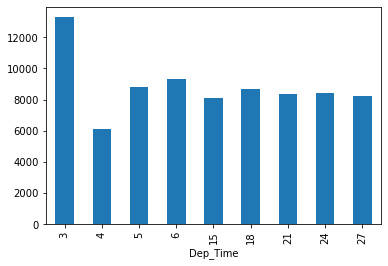

In [241]:
day_grouped = new_data.groupby(new_data["Dep_Time"].dt.day)["Price"].mean()
day_grouped.plot.bar()

## Can we see any relation with Additional Info?

In [242]:
new_data.groupby('Additional_Info')['Price'].mean()

Additional_Info
1 Long layover                  22109.631579
1 Short layover                 26743.000000
2 Long layover                  26480.000000
Business class                  56811.250000
Change airports                 16800.714286
In-flight meal not included      9471.834511
No Info                          8044.666667
No check-in baggage included     3645.156250
No info                          9141.320192
Red-eye flight                  10873.000000
Name: Price, dtype: float64

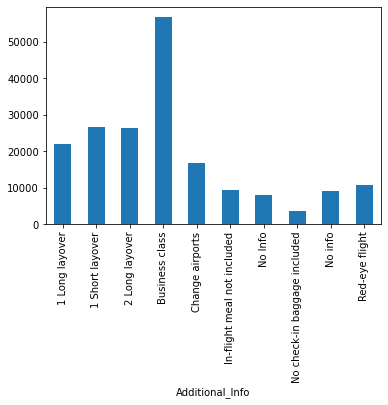

In [243]:
info_grouped = new_data.groupby('Additional_Info')['Price'].mean()
info_grouped.plot.bar()

## ***Busines class plays an important role***

## Does the minutes of Flight affect the price?

In [244]:
print("Max minutes: ",new_data["Minutes"].values.max())
print("Min minutes: ",new_data["Minutes"].values.min())

Max minutes:  2860
Min minutes:  75


In [245]:
NUM_BINS = (2860 - 75)//300
bins = np.linspace(75,2860,NUM_BINS) #Bins in the interval of 5 hours (300 mins)
hours_df = pd.cut(new_data['Minutes'], bins)

In [246]:
hours_df.head()

0       (75.0, 423.125]
1     (423.125, 771.25]
2    (1119.375, 1467.5]
3       (75.0, 423.125]
4       (75.0, 423.125]
Name: Minutes, dtype: category
Categories (8, interval[float64]): [(75.0, 423.125] < (423.125, 771.25] < (771.25, 1119.375] < (1119.375, 1467.5] < (1467.5, 1815.625] < (1815.625, 2163.75] < (2163.75, 2511.875] < (2511.875, 2860.0]]

In [247]:
new_data.groupby(hours_df)['Price'].mean()

Minutes
(75.0, 423.125]         6054.689157
(423.125, 771.25]      11134.966219
(771.25, 1119.375]     11035.499331
(1119.375, 1467.5]     12055.007380
(1467.5, 1815.625]     11617.182119
(1815.625, 2163.75]    12496.873563
(2163.75, 2511.875]    12127.000000
(2511.875, 2860.0]     16310.250000
Name: Price, dtype: float64

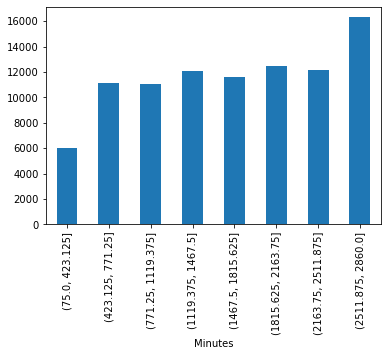

In [248]:
new_data.groupby(hours_df)['Price'].mean().plot.bar()

### **The price generally increases with increase in minutes**

## Does Source and Destination matters?

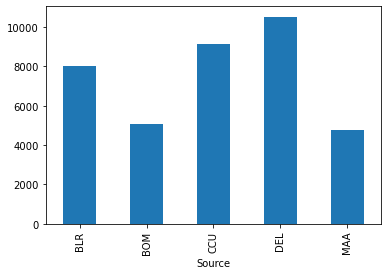

In [249]:
source_grouped = new_data.groupby('Source')["Price"].mean()
source_grouped.plot.bar()

Flights leaving from Delhi and CCU have a higher rate in general

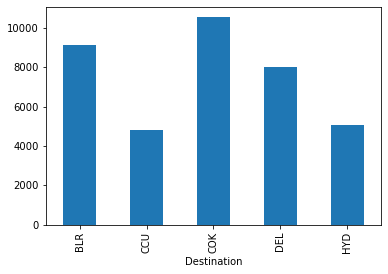

In [250]:
dest_grouped = new_data.groupby('Destination')["Price"].mean()
dest_grouped.plot.bar()

## Splitting Dep_Time into Hour, Day, Month

In [251]:
new_data.head()

,Airline,Source,Destination,Dep_Time,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,BLR,DEL,2019-03-24 22:20:00,170,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,CCU,BLR,2019-01-05 05:50:00,445,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,DEL,COK,2019-09-06 09:25:00,1140,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,CCU,BLR,2019-12-05 18:05:00,325,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,BLR,DEL,2019-01-03 16:50:00,285,1,No info,13302,NAG,NaN,NaN,NaN


**Now, split Dep_Time into different columns as: Day, Month and Hour**

1. The Day (Mon, Tue, Wed, etc) features affects the prices (graph above)<br>
2. The Month (Jan, March, etc) feature also affects the prices

In [252]:
#Creating a new dataframe
temp_df = new_data.copy()
temp_df["Dep_Day"] = new_data["Dep_Time"].dt.weekday.values
temp_df["Dep_Month"] = new_data["Dep_Time"].dt.month.values
temp_df["Dep_Hour"] = new_data["Dep_Time"].dt.hour.values
temp_df.drop(labels=["Dep_Time"], axis = 'columns', inplace = True)
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day,Dep_Month,Dep_Hour
0,IndiGo,BLR,DEL,170,0,No info,3897,NaN,NaN,NaN,NaN,6,3,22
1,Air India,CCU,BLR,445,2,No info,7662,IXR,BBI,NaN,NaN,5,1,5
2,Jet Airways,DEL,COK,1140,2,No info,13882,LKO,BOM,NaN,NaN,4,9,9
3,IndiGo,CCU,BLR,325,1,No info,6218,NAG,NaN,NaN,NaN,3,12,18
4,IndiGo,BLR,DEL,285,1,No info,13302,NAG,NaN,NaN,NaN,3,1,16


In [253]:
temp_df.loc[temp_df["Additional_Info"] == "No info", "Additional_Info"] = np.nan

### **Note: Days/Weekday are NOT Categorical nor Numerical, They are cyclic statistics

In [254]:
temp_df["Dep_Day"] = np.sin(2*np.pi*new_data["Dep_Time"].dt.day.values/7)
temp_df["Dep_Hour"] = np.sin(2*np.pi*new_data["Dep_Time"].dt.hour.values/24)
temp_df["Dep_Month"] = np.sin(2*np.pi*new_data["Dep_Time"].dt.month.values/12)
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day,Dep_Month,Dep_Hour
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,0.433884,1.000000e+00,-0.500000
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,-0.974928,5.000000e-01,0.965926
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,-0.781831,-1.000000e+00,0.707107
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,-0.974928,-2.449294e-16,-1.000000
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,0.433884,5.000000e-01,-0.866025


In [255]:
temp_df.rename({'Dep_Day':'Dep_Day_sine', 'Dep_Hour': 'Dep_Hour_sine', 'Dep_Month': 'Dep_Month_sine'},
               axis = 'columns', inplace = True)

In [256]:
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day_sine,Dep_Month_sine,Dep_Hour_sine
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,0.433884,1.000000e+00,-0.500000
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,-0.974928,5.000000e-01,0.965926
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,-0.781831,-1.000000e+00,0.707107
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,-0.974928,-2.449294e-16,-1.000000
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,0.433884,5.000000e-01,-0.866025


# Model Building 

### One- Hot Encoding

In [257]:
from sklearn.preprocessing import OneHotEncoder

In [258]:
categorical_features = ['Airline', 'Source', 'Destination','Additional_Info', 'Stop_1', 
                                            'Stop_2', 'Stop_3', 'Stop_4']

In [259]:
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day_sine,Dep_Month_sine,Dep_Hour_sine
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,0.433884,1.000000e+00,-0.500000
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,-0.974928,5.000000e-01,0.965926
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,-0.781831,-1.000000e+00,0.707107
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,-0.974928,-2.449294e-16,-1.000000
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,0.433884,5.000000e-01,-0.866025


In [260]:
one_hot = pd.get_dummies(temp_df[categorical_features])

In [261]:
one_hot.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,...,Stop_3_ AMD,Stop_3_ BBI,Stop_3_ BHO,Stop_3_ BOM,Stop_3_ DEL,Stop_3_ GWL,Stop_3_ HYD,Stop_3_ NAG,Stop_3_ TRV,Stop_4_ VGA
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [262]:
one_hot.shape

(10683, 106)

In [263]:
one_hot_df = pd.concat([temp_df, one_hot], axis = 1)

In [264]:
one_hot_df.drop(labels = categorical_features, axis = 'columns', inplace = True)

In [265]:
one_hot_df.head()

,Minutes,Total_Stops,Price,Dep_Day_sine,Dep_Month_sine,Dep_Hour_sine,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Stop_3_ AMD,Stop_3_ BBI,Stop_3_ BHO,Stop_3_ BOM,Stop_3_ DEL,Stop_3_ GWL,Stop_3_ HYD,Stop_3_ NAG,Stop_3_ TRV,Stop_4_ VGA
0,170,0,3897,0.433884,1.000000e+00,-0.500000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,445,2,7662,-0.974928,5.000000e-01,0.965926,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1140,2,13882,-0.781831,-1.000000e+00,0.707107,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,325,1,6218,-0.974928,-2.449294e-16,-1.000000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,285,1,13302,0.433884,5.000000e-01,-0.866025,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Training and Validation Set

In [266]:
y = one_hot_df["Price"].values
X = one_hot_df.drop(labels= ['Price'], axis = 'columns').values

In [267]:
print("X Shape: ",X.shape)
print("y Shape: ",y.shape)

X Shape:  (10683, 111)
y Shape:  (10683,)


In [268]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [269]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)
print("X_val Shape: ",X_val.shape)
print("y_val Shape: ",y_val.shape)

X_train Shape:  (8012, 111)
y_train Shape:  (8012,)
X_val Shape:  (2671, 111)
y_val Shape:  (2671,)


In [270]:
#Rescaling Minutes
X_train[:,0] /= X_train[:,0].max()
X_val[:,0] /= X_val[:,0].max()

# Making your own scorer: MSLE

In [271]:
from sklearn.metrics import make_scorer
import math

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def rmsle_score(y, y_pred):
    return 1 - rmsle(y, y_pred)

rmsle_scorer = make_scorer(rmsle_score, greater_is_better = True)

## Model 1: Linear Regression

In [274]:
from sklearn.linear_model import LinearRegression
lnr = LinearRegression()
lnr.fit(X_train, y_train)
y_pred = lnr.predict(X_val)
print("Linear Regression training score: ", 1 - rmsle(lnr.predict(X_train), y_train))

Linear Regression training score:  0.7533160465301535


# Model2: SVM Regression

In [275]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
print("SVR Regression training score",1 - rmsle(svr.predict(X_train), y_train))
print("SVR Regression validation score",1 - rmsle(svr.predict(X_val), y_val))

SVR Regression training score 0.515429183342486
SVR Regression validation score 0.5142638674018114


# XGBoost

In [281]:
!pip3 install xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
1 - rmsle(xgb.predict(X_train), y_train)
print("XGBoost training score: ",1 - rmsle(xgb.predict(X_train), y_train))
print("XGBoost validation score: ",1 - rmsle(xgb.predict(X_vl), y_val))

XGBoost training score:  0.8580374395897257
XGBoost validation score:  0.8180509242710574


# Model 4: RandomForestRegression

In [277]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
y_pred = rfg.predict(X_val)
print("Random forest training score: ", 1 - rmsle(rfg.predict(X_train), y_train))
print("Random forest validation score: ", 1 - rmsle(y_val, y_pred))

Random forest training score:  0.9050658255971102
Random forest validation score:  0.808956793438032


***Since we got highest validation score with XGBoost, Let's explore XGBoost a bit***

## Hyperparameter Tuning

In [284]:
from sklearn.model_selection import RandomizedSearchCV

In [285]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  

In [ ]:
gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)  

In [287]:
gs.best_params_

{'colsample_bytree': 0.8151140781415852,
 'gamma': 1.9286031934012904,
 'learning_rate': 0.2884647320623602,
 'max_depth': 39,
 'min_child_weight': 26.787780544869072,
 'n_estimators': 16,
 'reg_alpha': 18.53614468914483,
 'subsample': 0.9416558120813516}

In [288]:
gs.best_score_

0.7955871713106478

In [ ]:
gs.score(X_val, y_val)